In [3]:
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import rasterio.plot
import contextily as cx
import folium
%matplotlib inline

In [4]:
nz = gpd.read_file('data/nz.gpkg')
nz_height = gpd.read_file('data/nz_height.gpkg')
nz_elev = rasterio.open('data/nz_elev.tif')

### Static Map Elements

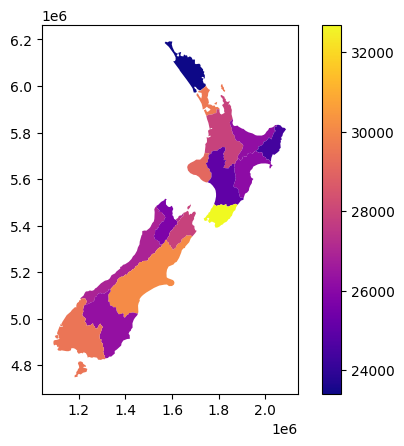

In [6]:
# plot a numeric column from a GeoDataFrame
nz.plot(column='Median_income', legend=True, cmap = 'plasma');

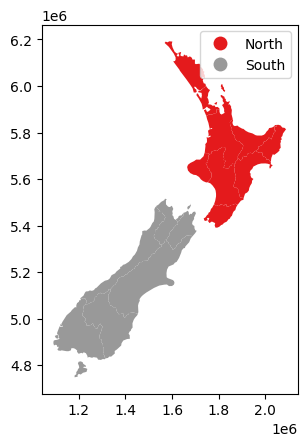

In [7]:
# plot a Categorical Column
nz.plot(column='Island', legend=True, cmap='Set1');

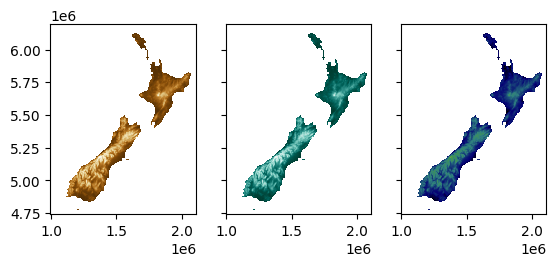

In [8]:
# Plotting rasters with rasterio.plot.show
fig, ax = plt.subplots(1, 3, sharey=True)
rasterio.plot.show(nz_elev, cmap='BrBG', ax = ax[0]);
rasterio.plot.show(nz_elev, cmap='BrBG_r', ax = ax[1]);
rasterio.plot.show(nz_elev, cmap='gist_earth', ax = ax[2]);

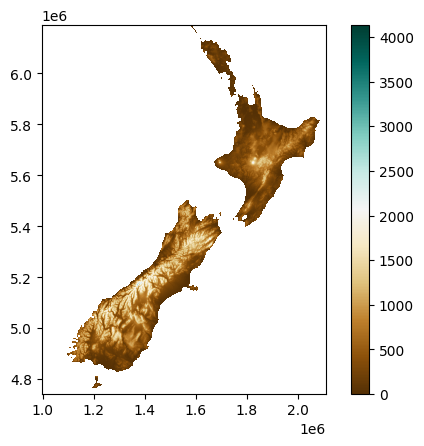

In [9]:
# Creating a legend with Matplotlib
fig, ax = plt.subplots()
i = plt.imshow(nz_elev.read(1), cmap='BrBG')
rasterio.plot.show(nz_elev, cmap='BrBG', ax=ax);
fig.colorbar(i, ax=ax);

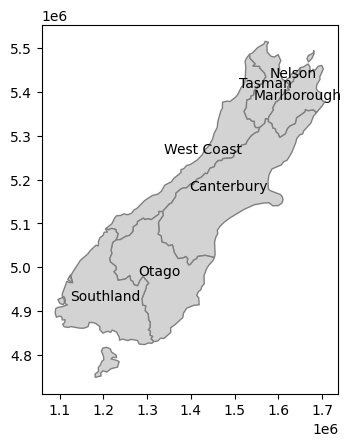

In [12]:
# add labels using the 'Annotate' method
nz1 = nz[nz['Island'] == 'South']

fig, ax = plt.subplots()
nz1.plot(ax=ax, color='lightgrey', edgecolor='grey')
nz1.apply(lambda x: ax.annotate(
        text=x['Name'], 
        xy=x.geometry.centroid.coords[0], 
        ha='center'), axis=1)
plt.show()

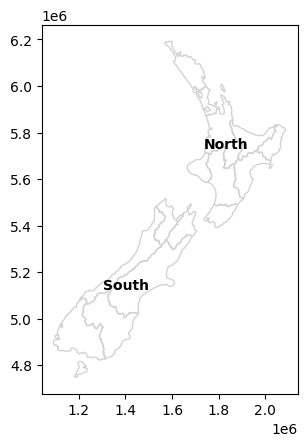

In [13]:
# Create a new GeoDataFrame to just store locations for label placement
# Here we're labeling the center of each Island
ctr = nz[['Island', 'geometry']].dissolve(by='Island').reset_index()
ctr['geometry'] = ctr.centroid

fig, ax = plt.subplots()
nz.plot(ax=ax, color='none', edgecolor='lightgrey')
ctr.apply(
    lambda x: ax.annotate(
        text=x['Island'], 
        xy=x.geometry.coords[0], 
        ha='center',
        weight='bold'
    ), 
    axis=1
)
plt.show()

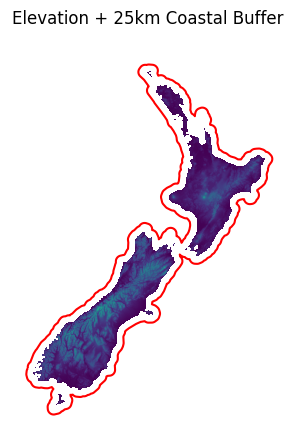

In [22]:
# plot raster + computed vector layer together
fig, ax = plt.subplots(figsize=(5, 5))
rasterio.plot.show(nz_elev, ax=ax)
gpd.GeoSeries(nz.union_all(), crs=nz.crs).to_crs(nz_elev.crs).buffer(25000).exterior.plot(ax=ax, color='red')
plt.title('Elevation + 25km Coastal Buffer')
ax.set_axis_off()
plt.show()

### Using Basemaps

Can add to basemaps using contextily

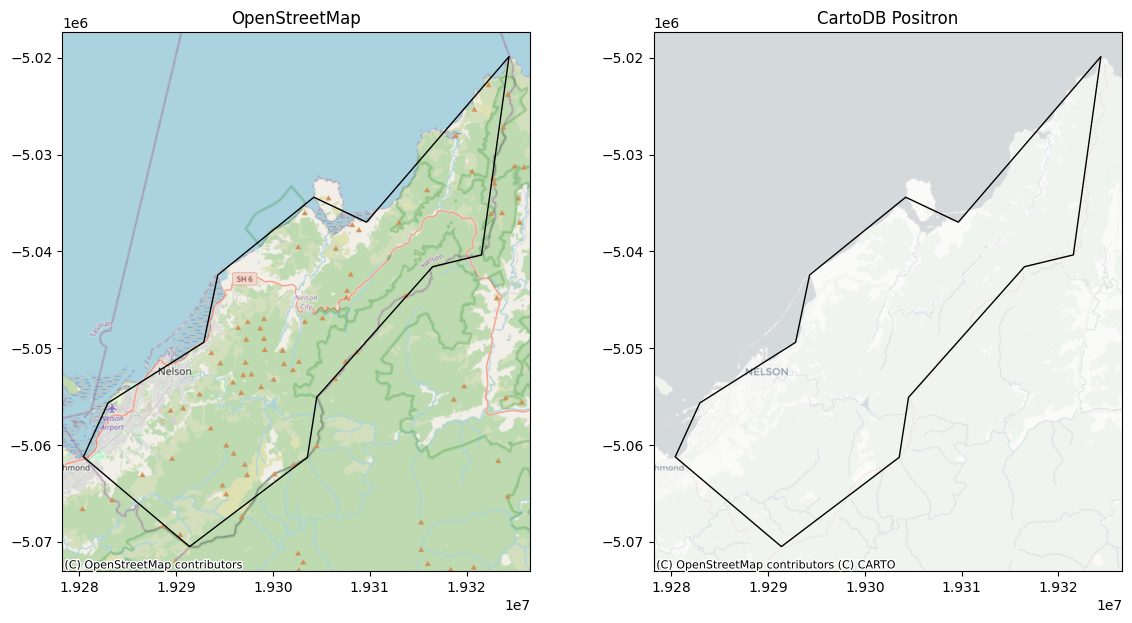

In [26]:
nzw = nz[nz['Name'] == 'Nelson'].to_crs(epsg=3857)

fig, ax = plt.subplots(1, 2, figsize=(14, 7))
nzw.plot(color='none', ax=ax[0])
cx.add_basemap(ax[0], source=cx.providers.OpenStreetMap.Mapnik);

# CartoDB.Positron
nzw.plot(color='none', ax=ax[1])
cx.add_basemap(ax[1], source=cx.providers.CartoDB.Positron)

ax[0].set_title('OpenStreetMap')
ax[1].set_title('CartoDB Positron')
plt.show()

### Interactive Maps

Can use the geopandas explore() method. Can also use more complex folium or leaflet based maps

In [27]:
nz_height.explore(marker_type='marker')

In [30]:
# Add more interactivity to map
# Specify Base Map source with tiles argument
m = nz.explore(name='Polygons (adm. areas)', tiles = 'CartoDB Positron')
nz_height.explore(m=m, color='red', name='Points (elevation)', tiles = 'CartoDB Positron')
folium.LayerControl(collapsed=False).add_to(m)
m

In [31]:
# Save to an html file
m = nz.explore(name='Polygons (adm. areas)')
nz_height.explore(m=m, color='red', name='Points (elevation)')
folium.LayerControl(collapsed=False).add_to(m)
m.save('output/map.html')